Problem statement :

Create a GUI so that we can write a digit ( 0-9), and after clicking recognize, the character is recognised along with the bounding box around it.

# 1. Load the Mnist dataset

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense


In [2]:
# Load mnist dataset:
data=keras.datasets.mnist.load_data()

x_train_raw_data = data[0][0]
y_train = data[0][1]

half_size = len(data[1][0]) // 2  # use half of the testing data for "test" and other half for validataion

x_test_raw_data = data[1][0][:half_size]
y_test = data[1][1][:half_size]


x_val_raw_data = data[1][0][half_size:]
y_val = data[1][1][half_size:]



print("Shape of x_train:", x_train_raw_data.shape)
print("Shape of y_train:", y_train.shape)


print("Shape of x_test:", x_test_raw_data.shape)
print("Shape of y_test:", y_test.shape)

print("Shape of x_val:", x_val_raw_data.shape)
print("Shape of y_val:", y_val.shape)

# Define a sharpening kernel
sharpen_kernel = np.array([[ 0, -1,  0],
                           [-1,  8, -1],
                           [ 0, -1,  0]])
FULL_SHAPE = (80,80)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (5000, 28, 28)
Shape of y_test: (5000,)
Shape of x_val: (5000, 28, 28)
Shape of y_val: (5000,)


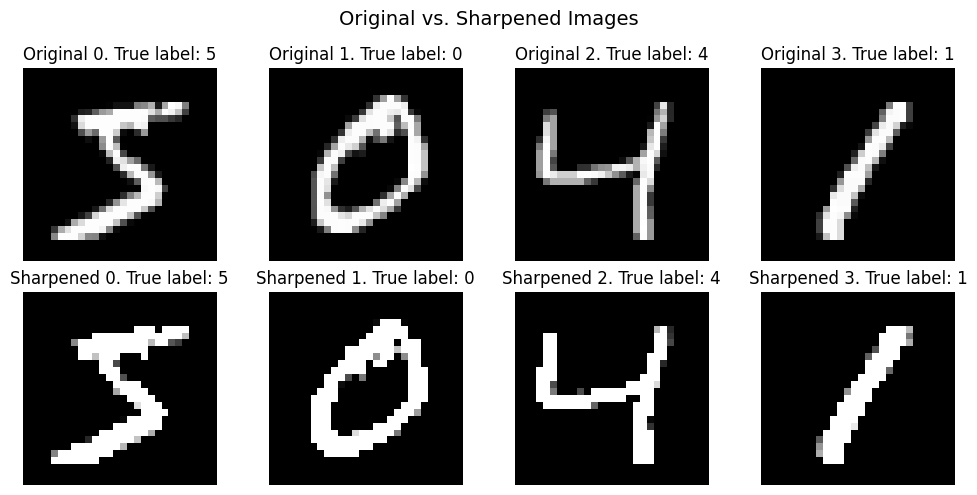

Final x_train_raw_data shape: (60000, 28, 28)
Final y_train shape: (60000,)


In [3]:
# Plot original and sharpened images side by side
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # 2 rows, 4 columns
fig.suptitle("Original vs. Sharpened Images", fontsize=14)

for i in range(4):
    original_img = x_train_raw_data[i]  # Original Image (28x28)
    sharpened_img = cv2.filter2D(original_img, -1, sharpen_kernel).astype(np.uint8)  # Ensuring same dtype
    # Original Image
    axes[0, i].imshow(original_img, cmap="gray")
    axes[0, i].set_title(f"Original {i}. True label: {y_train[i]}")
    axes[0, i].axis("off")

    # Sharpened Image
    axes[1, i].imshow(sharpened_img, cmap="gray")
    axes[1, i].set_title(f"Sharpened {i}. True label: {y_train[i]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

print("Final x_train_raw_data shape:", x_train_raw_data.shape)
print("Final y_train shape:", y_train.shape)

# 2. Preparing the data for object localization

In [4]:
def preprocess_and_create_data(x_raw_data):
    y_box=[]
    x_new=[]
    def localize_obj(img_id):
        img_height = np.random.randint(20,FULL_SHAPE[0]-20)
        img_width = np.random.randint(20,FULL_SHAPE[0]-20)

        new = np.zeros(FULL_SHAPE)
        x = np.random.randint(0,FULL_SHAPE[0]-img_height)
        y = np.random.randint(0,FULL_SHAPE[0]-img_width)

        original_img = x_raw_data[img_id]
        sharpened_img = cv2.filter2D(original_img, -1, sharpen_kernel)  #sharpen the image

        image = cv2.resize(sharpened_img, dsize=(img_width,img_height))

        new[x:x+img_height,y:y+img_width] = image
        x_new.append(new)
        y_box.append([y,x,img_height,img_width])


    # Normalize the images
    x_raw_data = x_raw_data / 255

    #cropping unnecessary part
    x_raw_data = x_raw_data[:, 2:26, 2:26]

    for i in range(len(x_raw_data)):
        localize_obj(i)
    return x_new,y_box

In [5]:
x_train,y_train_box_data = preprocess_and_create_data(x_train_raw_data)

In [6]:
x_test,y_test_box_data = preprocess_and_create_data(x_test_raw_data)

In [7]:
x_val,y_val_box_data = preprocess_and_create_data(x_val_raw_data)

[19, 48, 23, 33]


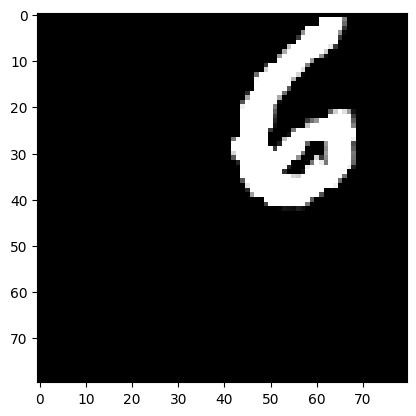

In [8]:
plt.imshow(x_train[90], cmap="gray", vmin=0, vmax=1)
print(y_train_box_data[1])

In [9]:
def plot_bb(img,x,y,height,width,pred_coords=[]):
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    x_coor = x
    y_coor = y
    plt.plot([x_coor,x_coor+width] , [y_coor,y_coor],color='g',linewidth=2)
    plt.plot([x_coor,x_coor+width] , [y_coor+height,y_coor+height],color='g',linewidth=2)
    plt.plot([x_coor,x_coor] , [y_coor,y_coor+height],color='g',linewidth=2)
    plt.plot([x_coor+width,x_coor+width] , [y_coor,y_coor+height],color='g',linewidth=2)
    if len(pred_coords)==4:
        x1,y1,hei,wid = pred_coords
        limit = FULL_SHAPE[0]-1
        if x1 < limit and y1 < limit :
            x2 =min(limit , x1+wid)
            y2 =min(limit , y1+hei )
            plt.plot([x1,x2] , [y1,y1],color='r',linewidth=2)
            plt.plot([x1,x2] , [y2,y2],color='r',linewidth=2)
            plt.plot([x1,x1] , [y1,y2],color='r',linewidth=2)
            plt.plot([x2,x2] , [y1,y2],color='r',linewidth=2)

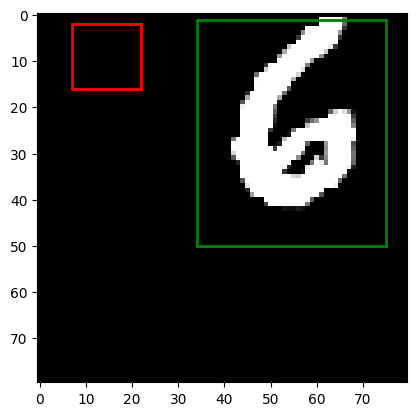

In [10]:
image_id = 90
plot_bb(x_train[image_id], y_train_box_data[image_id][0] , y_train_box_data[image_id][1] ,y_train_box_data[image_id][2] , y_train_box_data[image_id][3] , [7,2,14,15])

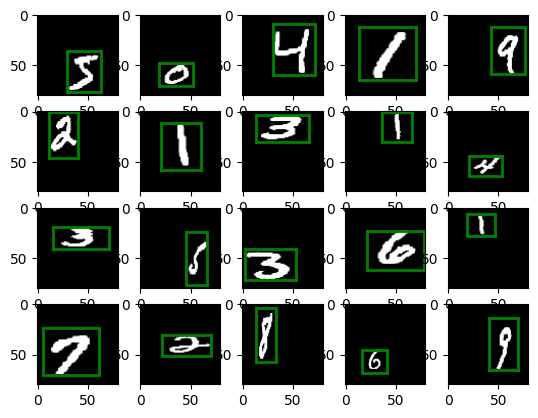

In [11]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plot_bb(x_train[i], y_train_box_data[i][0] , y_train_box_data[i][1],y_train_box_data[i][2],y_train_box_data[i][3])
plt.show()

In [12]:
def form_tensorflow_dataset(x, y, y_box):
    x = np.array(x).reshape(len(x), FULL_SHAPE[0], FULL_SHAPE[1], 1)
    y = np.array(y)  # Ensure y is a NumPy array
    y_box = np.array(y_box, dtype=np.float32)  # Convert y_box to NumPy array with explicit dtype

    dataset1 = tf.data.Dataset.from_tensor_slices(x.astype(np.float32))
    dataset2 = tf.data.Dataset.from_tensor_slices({'class_out': y, 'box_out': y_box})
    dataset = tf.data.Dataset.zip((dataset1, dataset2))
    dataset = dataset.shuffle(200)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(4)

    print(x.shape)
    print(y.shape)
    print(y_box.shape)  # Print shape instead of length
    return dataset


In [13]:
train_dataset = form_tensorflow_dataset(x_train,y_train, y_train_box_data)
test_dataset = form_tensorflow_dataset(x_test,y_test, y_test_box_data)
val_dataset = form_tensorflow_dataset(x_val,y_val, y_val_box_data)

(60000, 80, 80, 1)
(60000,)
(60000, 4)
(5000, 80, 80, 1)
(5000,)
(5000, 4)
(5000, 80, 80, 1)
(5000,)
(5000, 4)


In [14]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

1875
157
157


# 3. Creating CNN model for image classifiation and object localization

##### For better model performance :
- Data Augumentaion
- increase the complexity of the model
- use dropout regularization
- batch normalization
- Scale the image

In [15]:

# inp = Input(shape = x_train[0].shape , name = 'image')
# x = inp
# for i in range(0,3):
#     n_filters = 2**(4+i)
#     x = Conv2D(n_filters,3,activation="relu")(x)
#     x = MaxPool2D(2)(x)

# x = BatchNormalization()(x)
# x=Flatten()(x)
# x = Dense(512 , activation="relu")(x)
# x = Dense(256 , activation='relu')(x)

# class_out = Dense(10 , activation='softmax' , name='class_out')(x)


# box_out = Dense(4, name='box_out')(x)


# model = keras.models.Model(inp , [class_out,box_out])
# model.summary()


inp = Input(shape=x_train[0].shape + (1,), name='image')  # Expand the shape
x = inp

# First Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Dropout(0.25)(x)

# Second Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Dropout(0.25)(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layers
class_out = Dense(10, activation='softmax', name='class_out')(x)
box_out = Dense(4, name='box_out')(x)

model = Model(inp, [class_out, box_out])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 80, 80, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 80, 80, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 40, 40, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 40, 40, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 40, 40, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 40, 40, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 40, 40, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 20, 20, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 20, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │     13,107,712 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 13,719,278 (52.33 MB)

 Trainable params: 13,715,822 (52.32 MB)

 Non-trainable params: 3,456 (13.50 KB)

# 4. Custom metric : IOU
- getting error while using this as my metric, will find the solution soon

In [16]:
class IOU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IOU , self).__init__(**kwargs)

        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            y = tf.cast(y, tf.float32)
            rows, cols, height, width = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
            x1, y1 = rows, cols
            x2, y2 = x1 + width, y1 + height
            return x1, y1, x2, y2

        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        tx1, ty1, tx2, ty2 = get_box(y_true)
        px1, py1, px2, py2 = get_box(y_pred)

        x1 = tf.maximum(tx1, px1)
        x2 = tf.minimum(tx2, px2)
        y1 = tf.maximum(ty1, py1)
        y2 = tf.minimum(ty2, py2)

        i_area = get_area(x1, y1, x2, y2)
        u_area = get_area(tx1, ty1, tx2, ty2) + get_area(px1, py1, px2, py2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou.assign(tf.math.divide(self.total_iou, self.num_ex))

    def result(self):
        return self.iou

    def reset_state(self):
        self.iou.assign(0)
        self.total_iou.assign(0)
        self.num_ex.assign(0)


# 5. Compiling the model

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
loss = {
  'class_out' : 'sparse_categorical_crossentropy',
    'box_out':'mse'
},

optimizer=optimizer,
metrics={
    'class_out' :'accuracy',
    'box_out':IOU()                   # here we need to define our custom metric : IOU
}
)

#Define LearningRateScheduler
reduce_lr = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


# 6. Custom callback : Model testing

In [18]:
testing = test_dataset.take(1)
for i in testing.as_numpy_iterator():
    img = i[0]
    y_true= i[1]['class_out']
    bb_true = i[1]['box_out']

In [19]:
def test_model(model) :
    c,bb_pred =model.predict(img)

    y_pred = []
    for i in c:
        y_pred.append(np.argmax(i))
    y_pred=np.array(y_pred).reshape(len(c),1)

    # we have y_true,y_pred,bb_true,bb_pred

    for i in range(5):
        plt.subplot(1,5,i+1)
        plot_bb(img[i], bb_true[i][0] , bb_true[i][1],bb_true[i][2],bb_true[i][3], bb_pred[i])
#         plt.xlabel('Truth : '+str( y_true[i][0]))
        plt.xlabel('pred : '+ str(y_pred[i][0]) )
        plt.xticks([])
        plt.yticks([])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


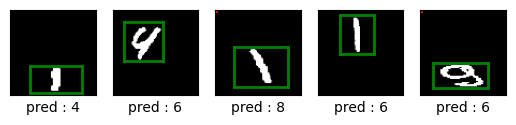

In [20]:
test_model(model)

In [21]:
# creating clustom callback so that we can view the test iages while training itself.

class ShowValImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        test_model(self.model)

In [22]:
callbacks_list = [ShowValImages(), reduce_lr]

# 7. Training the model - i've done the training on colab

Epoch 1/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


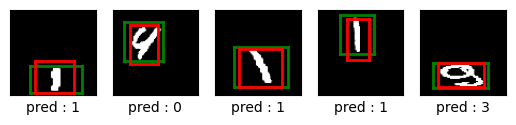

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - box_out_iou: 0.4054 - box_out_loss: 285.8929 - class_out_accuracy: 0.1292 - class_out_loss: 2.8523 - loss: 288.7451 - val_box_out_iou: 0.6636 - val_box_out_loss: 35.1966 - val_class_out_accuracy: 0.2004 - val_class_out_loss: 2.2025 - val_loss: 37.3916 - learning_rate: 0.0010
Epoch 2/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


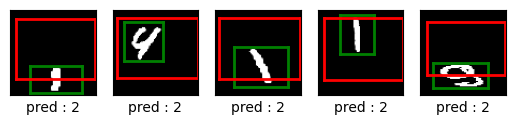

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - box_out_iou: 0.6814 - box_out_loss: 17.1086 - class_out_accuracy: 0.1898 - class_out_loss: 2.2617 - loss: 19.3703 - val_box_out_iou: 0.2865 - val_box_out_loss: 794.4460 - val_class_out_accuracy: 0.1002 - val_class_out_loss: 5.8072 - val_loss: 801.0861 - learning_rate: 9.0000e-04
Epoch 3/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


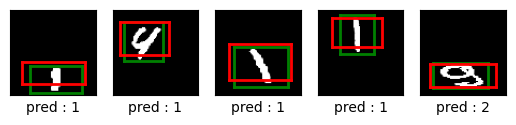

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7105 - box_out_loss: 13.4921 - class_out_accuracy: 0.2290 - class_out_loss: 2.0806 - loss: 15.5727 - val_box_out_iou: 0.7129 - val_box_out_loss: 36.3155 - val_class_out_accuracy: 0.2754 - val_class_out_loss: 1.8517 - val_loss: 38.2877 - learning_rate: 8.1000e-04
Epoch 4/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


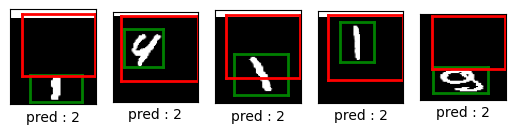

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7196 - box_out_loss: 12.5516 - class_out_accuracy: 0.2770 - class_out_loss: 1.9068 - loss: 14.4584 - val_box_out_iou: 0.2334 - val_box_out_loss: 958.8297 - val_class_out_accuracy: 0.1004 - val_class_out_loss: 11.8116 - val_loss: 970.6083 - learning_rate: 7.2900e-04
Epoch 5/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


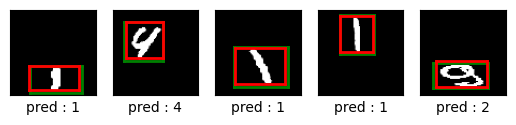

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7273 - box_out_loss: 11.6901 - class_out_accuracy: 0.3876 - class_out_loss: 1.6172 - loss: 13.3073 - val_box_out_iou: 0.8607 - val_box_out_loss: 4.2207 - val_class_out_accuracy: 0.5846 - val_class_out_loss: 1.0876 - val_loss: 5.3105 - learning_rate: 6.5610e-04
Epoch 6/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


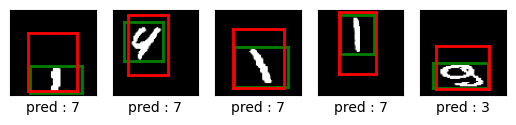

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - box_out_iou: 0.7369 - box_out_loss: 10.9808 - class_out_accuracy: 0.4890 - class_out_loss: 1.3514 - loss: 12.3322 - val_box_out_iou: 0.5727 - val_box_out_loss: 105.3312 - val_class_out_accuracy: 0.1136 - val_class_out_loss: 8.5087 - val_loss: 113.8543 - learning_rate: 5.9049e-04
Epoch 7/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


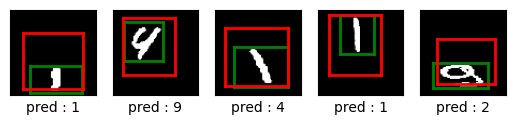

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - box_out_iou: 0.7391 - box_out_loss: 10.8411 - class_out_accuracy: 0.5523 - class_out_loss: 1.1923 - loss: 12.0334 - val_box_out_iou: 0.4858 - val_box_out_loss: 161.2341 - val_class_out_accuracy: 0.3902 - val_class_out_loss: 1.6823 - val_loss: 162.8877 - learning_rate: 5.3144e-04
Epoch 8/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


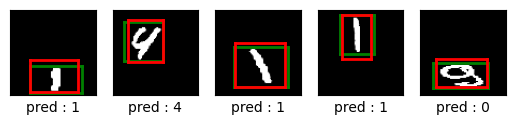

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - box_out_iou: 0.7377 - box_out_loss: 10.8301 - class_out_accuracy: 0.6087 - class_out_loss: 1.0541 - loss: 11.8842 - val_box_out_iou: 0.8117 - val_box_out_loss: 6.9579 - val_class_out_accuracy: 0.5066 - val_class_out_loss: 1.3503 - val_loss: 8.2951 - learning_rate: 4.7830e-04
Epoch 9/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


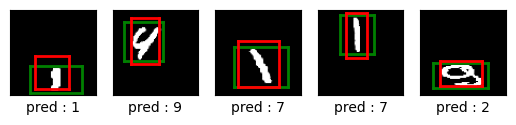

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7389 - box_out_loss: 10.5017 - class_out_accuracy: 0.6552 - class_out_loss: 0.9446 - loss: 11.4463 - val_box_out_iou: 0.6742 - val_box_out_loss: 38.5504 - val_class_out_accuracy: 0.4292 - val_class_out_loss: 1.8019 - val_loss: 40.3728 - learning_rate: 4.3047e-04
Epoch 10/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


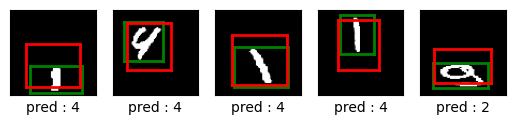

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - box_out_iou: 0.7390 - box_out_loss: 10.4260 - class_out_accuracy: 0.7012 - class_out_loss: 0.8437 - loss: 11.2697 - val_box_out_iou: 0.6216 - val_box_out_loss: 38.9191 - val_class_out_accuracy: 0.2076 - val_class_out_loss: 3.1384 - val_loss: 42.1334 - learning_rate: 3.8742e-04
Epoch 11/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


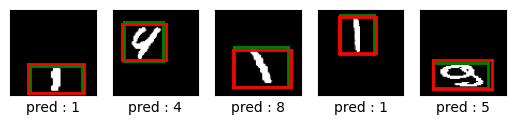

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - box_out_iou: 0.7431 - box_out_loss: 10.1346 - class_out_accuracy: 0.7355 - class_out_loss: 0.7546 - loss: 10.8892 - val_box_out_iou: 0.8122 - val_box_out_loss: 12.3736 - val_class_out_accuracy: 0.6796 - val_class_out_loss: 1.0962 - val_loss: 13.5107 - learning_rate: 3.4868e-04
Epoch 12/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


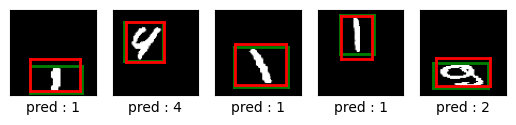

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7428 - box_out_loss: 9.8708 - class_out_accuracy: 0.7673 - class_out_loss: 0.6773 - loss: 10.5480 - val_box_out_iou: 0.8298 - val_box_out_loss: 4.3353 - val_class_out_accuracy: 0.8468 - val_class_out_loss: 0.4560 - val_loss: 4.7874 - learning_rate: 3.1381e-04
Epoch 13/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


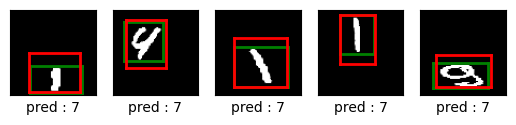

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7420 - box_out_loss: 10.0493 - class_out_accuracy: 0.7861 - class_out_loss: 0.6197 - loss: 10.6690 - val_box_out_iou: 0.7558 - val_box_out_loss: 15.8573 - val_class_out_accuracy: 0.2818 - val_class_out_loss: 2.8946 - val_loss: 18.7464 - learning_rate: 2.8243e-04
Epoch 14/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


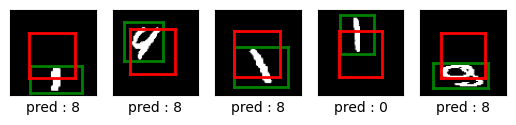

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7430 - box_out_loss: 10.0636 - class_out_accuracy: 0.8060 - class_out_loss: 0.5819 - loss: 10.6455 - val_box_out_iou: 0.3949 - val_box_out_loss: 139.6787 - val_class_out_accuracy: 0.1966 - val_class_out_loss: 4.0933 - val_loss: 143.5649 - learning_rate: 2.5419e-04
Epoch 15/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


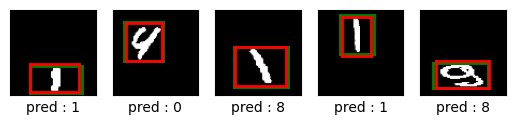

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7444 - box_out_loss: 9.8267 - class_out_accuracy: 0.8203 - class_out_loss: 0.5285 - loss: 10.3552 - val_box_out_iou: 0.8564 - val_box_out_loss: 4.1079 - val_class_out_accuracy: 0.7474 - val_class_out_loss: 0.7777 - val_loss: 4.8821 - learning_rate: 2.2877e-04
Epoch 16/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


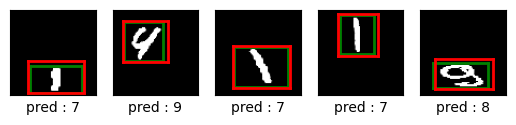

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7469 - box_out_loss: 9.7890 - class_out_accuracy: 0.8321 - class_out_loss: 0.4999 - loss: 10.2890 - val_box_out_iou: 0.8355 - val_box_out_loss: 6.4622 - val_class_out_accuracy: 0.8150 - val_class_out_loss: 0.5280 - val_loss: 6.9847 - learning_rate: 2.0589e-04
Epoch 17/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


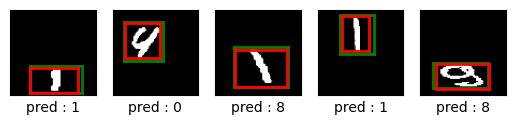

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7491 - box_out_loss: 9.5612 - class_out_accuracy: 0.8439 - class_out_loss: 0.4732 - loss: 10.0344 - val_box_out_iou: 0.8179 - val_box_out_loss: 7.4378 - val_class_out_accuracy: 0.5762 - val_class_out_loss: 1.5437 - val_loss: 8.9754 - learning_rate: 1.8530e-04
Epoch 18/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


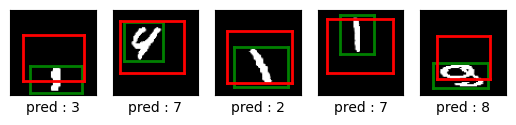

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7484 - box_out_loss: 9.6176 - class_out_accuracy: 0.8527 - class_out_loss: 0.4512 - loss: 10.0688 - val_box_out_iou: 0.4617 - val_box_out_loss: 206.0962 - val_class_out_accuracy: 0.3674 - val_class_out_loss: 2.6669 - val_loss: 208.8423 - learning_rate: 1.6677e-04
Epoch 19/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


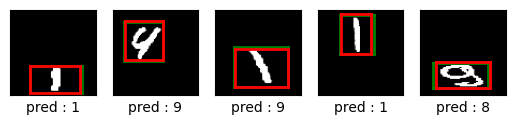

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7471 - box_out_loss: 9.6142 - class_out_accuracy: 0.8600 - class_out_loss: 0.4315 - loss: 10.0457 - val_box_out_iou: 0.8979 - val_box_out_loss: 2.2331 - val_class_out_accuracy: 0.9122 - val_class_out_loss: 0.2665 - val_loss: 2.5008 - learning_rate: 1.5009e-04
Epoch 20/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


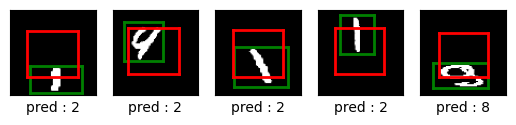

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7465 - box_out_loss: 9.7329 - class_out_accuracy: 0.8645 - class_out_loss: 0.4125 - loss: 10.1454 - val_box_out_iou: 0.4088 - val_box_out_loss: 146.4379 - val_class_out_accuracy: 0.1964 - val_class_out_loss: 4.2374 - val_loss: 150.9127 - learning_rate: 1.3509e-04
Epoch 21/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


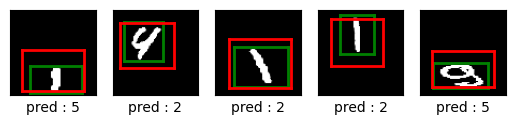

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7471 - box_out_loss: 9.5930 - class_out_accuracy: 0.8674 - class_out_loss: 0.4025 - loss: 9.9955 - val_box_out_iou: 0.6426 - val_box_out_loss: 57.6506 - val_class_out_accuracy: 0.2968 - val_class_out_loss: 4.8295 - val_loss: 62.4450 - learning_rate: 1.2158e-04
Epoch 22/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


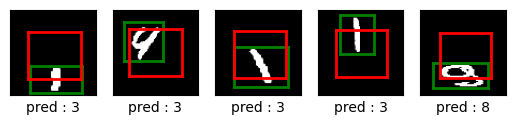

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7473 - box_out_loss: 9.7323 - class_out_accuracy: 0.8741 - class_out_loss: 0.3894 - loss: 10.1217 - val_box_out_iou: 0.3982 - val_box_out_loss: 159.5417 - val_class_out_accuracy: 0.1290 - val_class_out_loss: 4.2806 - val_loss: 163.7263 - learning_rate: 1.0942e-04
Epoch 23/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


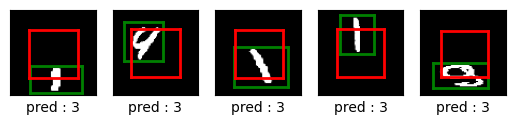

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7474 - box_out_loss: 9.4977 - class_out_accuracy: 0.8730 - class_out_loss: 0.3910 - loss: 9.8887 - val_box_out_iou: 0.3869 - val_box_out_loss: 160.0999 - val_class_out_accuracy: 0.1028 - val_class_out_loss: 5.5298 - val_loss: 165.3796 - learning_rate: 9.8477e-05
Epoch 24/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


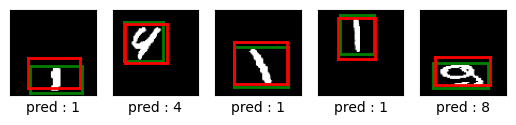

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7488 - box_out_loss: 9.4091 - class_out_accuracy: 0.8760 - class_out_loss: 0.3766 - loss: 9.7857 - val_box_out_iou: 0.8151 - val_box_out_loss: 4.1422 - val_class_out_accuracy: 0.7758 - val_class_out_loss: 0.6887 - val_loss: 4.8342 - learning_rate: 8.8629e-05
Epoch 25/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


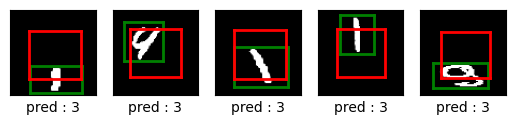

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7465 - box_out_loss: 9.6491 - class_out_accuracy: 0.8812 - class_out_loss: 0.3632 - loss: 10.0122 - val_box_out_iou: 0.3945 - val_box_out_loss: 161.9891 - val_class_out_accuracy: 0.1086 - val_class_out_loss: 5.3013 - val_loss: 167.5240 - learning_rate: 7.9766e-05
Epoch 26/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


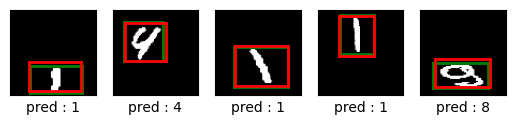

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7494 - box_out_loss: 9.5168 - class_out_accuracy: 0.8803 - class_out_loss: 0.3594 - loss: 9.8762 - val_box_out_iou: 0.8625 - val_box_out_loss: 2.1282 - val_class_out_accuracy: 0.9330 - val_class_out_loss: 0.2061 - val_loss: 2.3372 - learning_rate: 7.1790e-05
Epoch 27/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


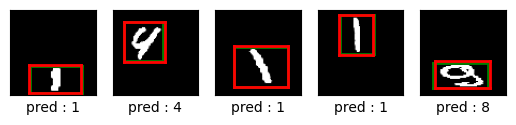

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7496 - box_out_loss: 9.4436 - class_out_accuracy: 0.8855 - class_out_loss: 0.3528 - loss: 9.7964 - val_box_out_iou: 0.9269 - val_box_out_loss: 0.6841 - val_class_out_accuracy: 0.9458 - val_class_out_loss: 0.1657 - val_loss: 0.8490 - learning_rate: 6.4611e-05
Epoch 28/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


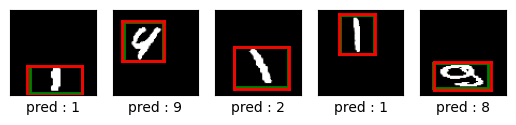

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7496 - box_out_loss: 9.4840 - class_out_accuracy: 0.8869 - class_out_loss: 0.3524 - loss: 9.8365 - val_box_out_iou: 0.9087 - val_box_out_loss: 1.8861 - val_class_out_accuracy: 0.8648 - val_class_out_loss: 0.4436 - val_loss: 2.3284 - learning_rate: 5.8150e-05
Epoch 29/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


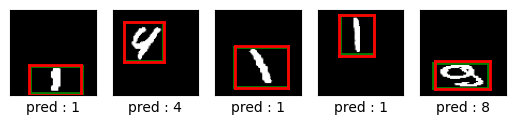

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7520 - box_out_loss: 9.1741 - class_out_accuracy: 0.8886 - class_out_loss: 0.3463 - loss: 9.5205 - val_box_out_iou: 0.9155 - val_box_out_loss: 1.1934 - val_class_out_accuracy: 0.9480 - val_class_out_loss: 0.1716 - val_loss: 1.3648 - learning_rate: 5.2335e-05
Epoch 30/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


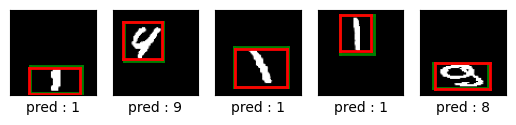

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7504 - box_out_loss: 9.2628 - class_out_accuracy: 0.8945 - class_out_loss: 0.3307 - loss: 9.5935 - val_box_out_iou: 0.9016 - val_box_out_loss: 1.7783 - val_class_out_accuracy: 0.9340 - val_class_out_loss: 0.2330 - val_loss: 2.0099 - learning_rate: 4.7101e-05
Epoch 31/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


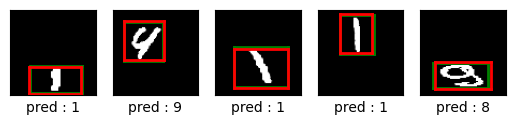

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7498 - box_out_loss: 9.5087 - class_out_accuracy: 0.8929 - class_out_loss: 0.3308 - loss: 9.8396 - val_box_out_iou: 0.9258 - val_box_out_loss: 0.9626 - val_class_out_accuracy: 0.9482 - val_class_out_loss: 0.1678 - val_loss: 1.1306 - learning_rate: 4.2391e-05
Epoch 32/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


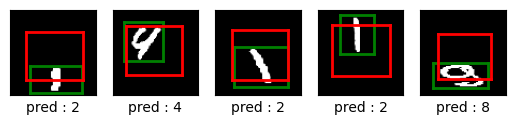

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - box_out_iou: 0.7536 - box_out_loss: 9.0791 - class_out_accuracy: 0.8931 - class_out_loss: 0.3277 - loss: 9.4068 - val_box_out_iou: 0.4341 - val_box_out_loss: 166.3886 - val_class_out_accuracy: 0.2224 - val_class_out_loss: 2.8045 - val_loss: 168.6449 - learning_rate: 3.8152e-05
Epoch 33/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


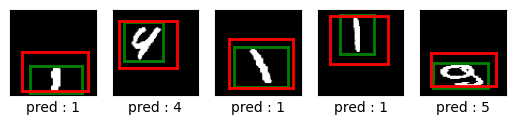

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7505 - box_out_loss: 9.2139 - class_out_accuracy: 0.8930 - class_out_loss: 0.3285 - loss: 9.5424 - val_box_out_iou: 0.5982 - val_box_out_loss: 106.4206 - val_class_out_accuracy: 0.7836 - val_class_out_loss: 0.6876 - val_loss: 107.0126 - learning_rate: 3.4337e-05
Epoch 34/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


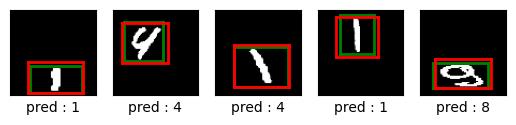

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7489 - box_out_loss: 9.4925 - class_out_accuracy: 0.8955 - class_out_loss: 0.3170 - loss: 9.8095 - val_box_out_iou: 0.8176 - val_box_out_loss: 8.5426 - val_class_out_accuracy: 0.8992 - val_class_out_loss: 0.3097 - val_loss: 8.8639 - learning_rate: 3.0903e-05
Epoch 35/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


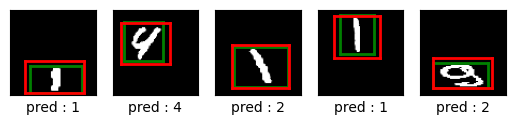

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7488 - box_out_loss: 9.3895 - class_out_accuracy: 0.8979 - class_out_loss: 0.3150 - loss: 9.7045 - val_box_out_iou: 0.7661 - val_box_out_loss: 20.3112 - val_class_out_accuracy: 0.8422 - val_class_out_loss: 0.4748 - val_loss: 20.8127 - learning_rate: 2.7813e-05
Epoch 36/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


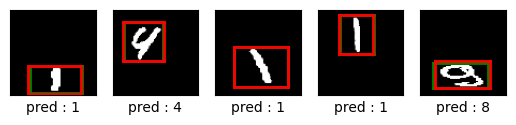

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7517 - box_out_loss: 9.1704 - class_out_accuracy: 0.8969 - class_out_loss: 0.3146 - loss: 9.4849 - val_box_out_iou: 0.9382 - val_box_out_loss: 0.5829 - val_class_out_accuracy: 0.9562 - val_class_out_loss: 0.1500 - val_loss: 0.7298 - learning_rate: 2.5032e-05
Epoch 37/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


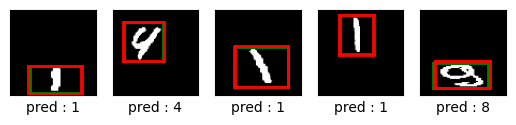

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7511 - box_out_loss: 9.1758 - class_out_accuracy: 0.8989 - class_out_loss: 0.3118 - loss: 9.4876 - val_box_out_iou: 0.9355 - val_box_out_loss: 0.6779 - val_class_out_accuracy: 0.9612 - val_class_out_loss: 0.1376 - val_loss: 0.8090 - learning_rate: 2.2528e-05
Epoch 38/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


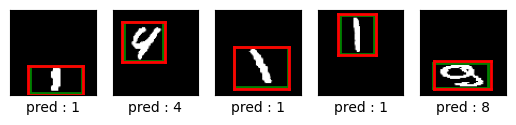

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - box_out_iou: 0.7518 - box_out_loss: 9.1098 - class_out_accuracy: 0.8990 - class_out_loss: 0.3142 - loss: 9.4240 - val_box_out_iou: 0.8942 - val_box_out_loss: 2.8626 - val_class_out_accuracy: 0.9604 - val_class_out_loss: 0.1418 - val_loss: 3.0074 - learning_rate: 2.0276e-05
Epoch 39/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


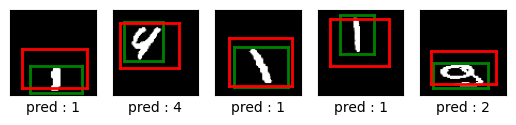

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - box_out_iou: 0.7500 - box_out_loss: 9.4135 - class_out_accuracy: 0.8999 - class_out_loss: 0.3095 - loss: 9.7231 - val_box_out_iou: 0.5749 - val_box_out_loss: 118.8004 - val_class_out_accuracy: 0.6364 - val_class_out_loss: 1.4019 - val_loss: 120.0663 - learning_rate: 1.8248e-05
Epoch 40/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


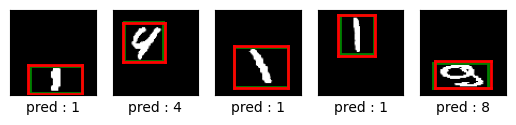

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - box_out_iou: 0.7518 - box_out_loss: 9.2972 - class_out_accuracy: 0.8963 - class_out_loss: 0.3219 - loss: 9.6190 - val_box_out_iou: 0.9084 - val_box_out_loss: 1.6020 - val_class_out_accuracy: 0.9288 - val_class_out_loss: 0.2184 - val_loss: 1.8234 - learning_rate: 1.6423e-05
Epoch 41/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


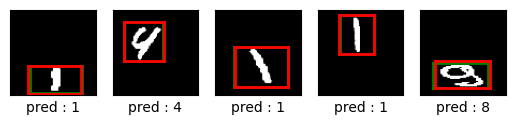

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7498 - box_out_loss: 9.2430 - class_out_accuracy: 0.9015 - class_out_loss: 0.3120 - loss: 9.5550 - val_box_out_iou: 0.9371 - val_box_out_loss: 0.6654 - val_class_out_accuracy: 0.9642 - val_class_out_loss: 0.1271 - val_loss: 0.7919 - learning_rate: 1.4781e-05
Epoch 42/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


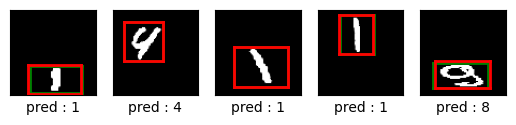

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7504 - box_out_loss: 9.3131 - class_out_accuracy: 0.8995 - class_out_loss: 0.3106 - loss: 9.6237 - val_box_out_iou: 0.9354 - val_box_out_loss: 0.6391 - val_class_out_accuracy: 0.9652 - val_class_out_loss: 0.1204 - val_loss: 0.7602 - learning_rate: 1.3303e-05
Epoch 43/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


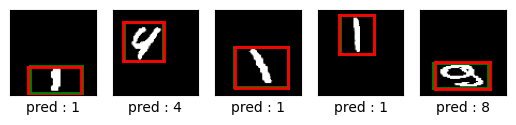

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - box_out_iou: 0.7512 - box_out_loss: 9.3064 - class_out_accuracy: 0.9034 - class_out_loss: 0.3067 - loss: 9.6131 - val_box_out_iou: 0.9349 - val_box_out_loss: 0.7820 - val_class_out_accuracy: 0.9634 - val_class_out_loss: 0.1285 - val_loss: 0.9109 - learning_rate: 1.1973e-05
Epoch 44/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


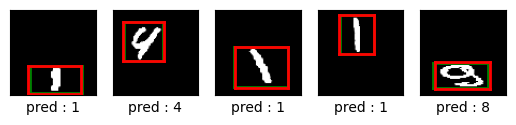

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7506 - box_out_loss: 9.1108 - class_out_accuracy: 0.9026 - class_out_loss: 0.3069 - loss: 9.4177 - val_box_out_iou: 0.9333 - val_box_out_loss: 0.8561 - val_class_out_accuracy: 0.9608 - val_class_out_loss: 0.1326 - val_loss: 0.9882 - learning_rate: 1.0775e-05
Epoch 45/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


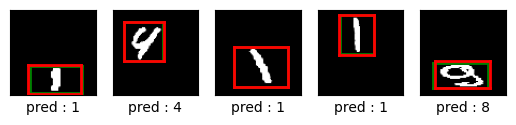

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - box_out_iou: 0.7507 - box_out_loss: 9.1694 - class_out_accuracy: 0.9022 - class_out_loss: 0.3019 - loss: 9.4713 - val_box_out_iou: 0.9297 - val_box_out_loss: 0.7928 - val_class_out_accuracy: 0.9602 - val_class_out_loss: 0.1306 - val_loss: 0.9234 - learning_rate: 9.6977e-06


In [23]:
history = model.fit(train_dataset,epochs=45,validation_data=val_dataset,callbacks=callbacks_list)

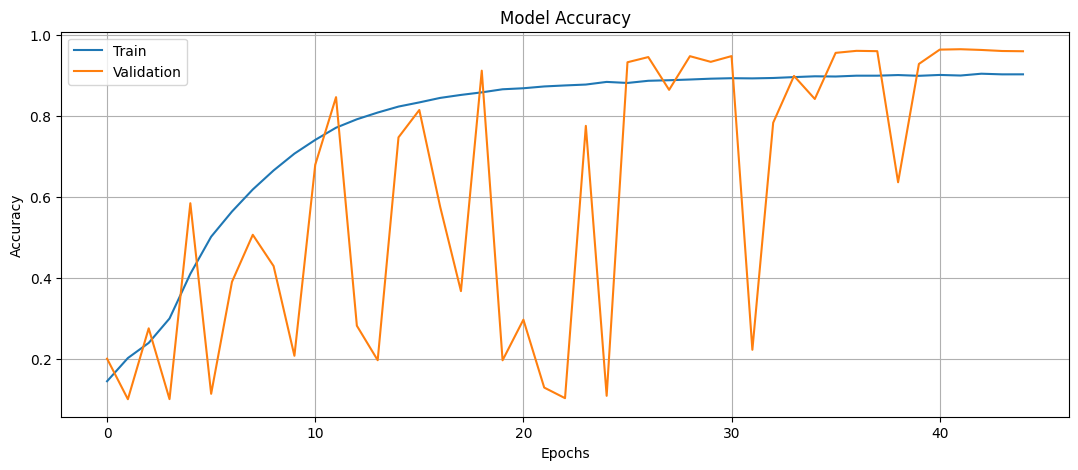

In [24]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['class_out_accuracy'])
plt.plot(history.history['val_class_out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

# 8. Saving/Loading the model

In [25]:
model.save('digits_localization_model_version2.keras')

# 9. Testing and Evaluating the model

In [26]:
def predict(i):
    yyyy , bbbb = model.predict(x_train[i].reshape(1,FULL_SHAPE[0],FULL_SHAPE[1],1))
    plot_bb(x_train[i], y_train_box_data[i][0] , y_train_box_data[i][1],y_train_box_data[i][2],y_train_box_data[i][3] , bbbb[0])
    plt.xlabel("Truth : "+ str(y_train[i]))
    plt.ylabel("Predicted : "+ str(np.argmax(yyyy)))
    plt.show()

def test_model(model) :
  c,bb_pred =model.predict(img)

  y_pred = []
  for i in c:
      y_pred.append(np.argmax(i))
  y_pred=np.array(y_pred).reshape(len(c),1)

  # we have y_true,y_pred,bb_true,bb_pred

  for i in range(8):
      plt.subplot(1,8,i+1)
      plot_bb(img[i], bb_true[i][0] , bb_true[i][1],bb_true[i][2],bb_true[i][3], bb_pred[i])
#         plt.xlabel('Truth : '+str( y_true[i][0]))
      plt.xlabel('pred : '+ str(y_pred[i][0]) )
      plt.xticks([])
      plt.yticks([])
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


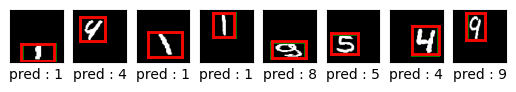

In [27]:
# for i in range(10):
    # predict(21+i)
test_model(model)

In [28]:
model.evaluate(train_dataset)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - box_out_iou: 0.9352 - box_out_loss: 0.6397 - class_out_accuracy: 0.9721 - class_out_loss: 0.0967 - loss: 0.7363


[0.7329382300376892,
 0.09310879558324814,
 0.6398298740386963,
 0.934971809387207,
 0.973633348941803]

In [29]:
model.evaluate(val_dataset)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - box_out_iou: 0.9300 - box_out_loss: 0.7702 - class_out_accuracy: 0.9634 - class_out_loss: 0.1175 - loss: 0.8877


[0.9234164357185364,
 0.13084757328033447,
 0.7924889922142029,
 0.9296555519104004,
 0.9602000117301941]

In [30]:
imgs=[]
y_true=[]
bb_true=[]
for i in val_dataset.as_numpy_iterator():
    imgs.append(i[0])

    y_true.append(np.expand_dims(i[1]['class_out'], axis=1))
    bb_true.append(i[1]['box_out'])
imgs=np.vstack(imgs)
y_true=np.vstack(y_true)
bb_true=np.vstack(bb_true)

In [31]:
c,bb_pred =model.predict(imgs)
y_pred = []
for i in c:
    y_pred.append(np.argmax(i))
y_pred=np.array(y_pred).reshape(len(c),1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [32]:
print( len(y_pred))
print(len(imgs))
print(len(bb_true))
print(len(y_true))

5000
5000
5000
5000


In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(accuracy_score(y_pred,y_true))
print("_____________________________________________________")
print(classification_report(y_pred,y_true))
print("_____________________________________________________")
cm=confusion_matrix(y_pred,y_true)
print(cm)

0.9602
_____________________________________________________
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       547
           1       0.99      0.99      0.99       560
           2       0.93      0.95      0.94       493
           3       0.95      0.99      0.97       490
           4       0.96      0.97      0.96       474
           5       0.96      0.98      0.97       428
           6       0.99      0.96      0.97       513
           7       0.97      0.97      0.97       511
           8       0.93      0.92      0.92       492
           9       0.95      0.94      0.94       492

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

_____________________________________________________
[[512   0  16   0   4   0   2   0  10   3]
 [  0 557   0   0   1   0   0   1   1   0]
 [  3   0 468  12   0   1   3   4   0   

Text(95.72222222222221, 0.5, 'Truth')

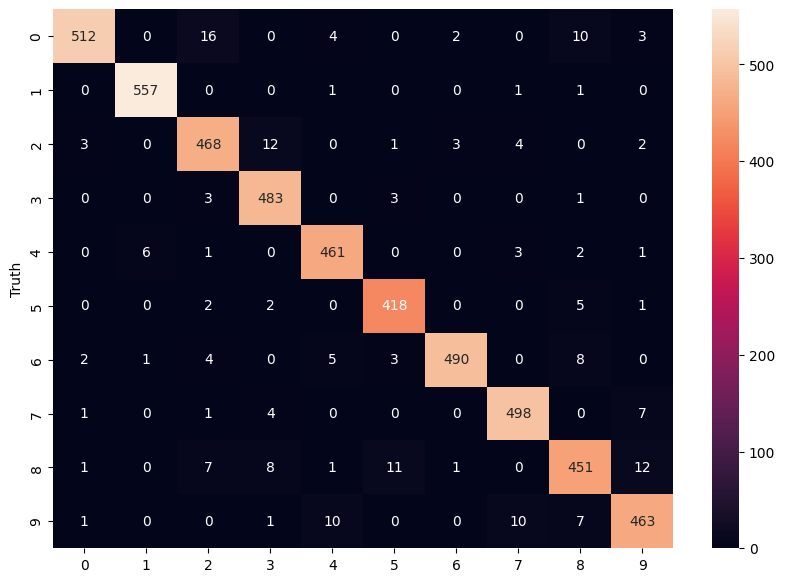

In [34]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.ylabel("Truth")

# 10. Recognizing handwritten digits on paint app:

In [35]:
loaded_model = tf.keras.models.load_model(
    "digits_localization_model_version2.h5",
    custom_objects={'IOU': IOU, 'mse': keras.losses.MeanSquaredError()}
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'digits_localization_model_version2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from pprint import pprint


from tkinter import *
import PIL.ImageGrab as ImageGrab
import numpy as np
import cv2
import matplotlib.pyplot as plt

root = Tk()
root.geometry('450x450+668+100')
root.title('Hand writing recognition')

ws = root.winfo_screenwidth() # width of the screen
hs = root.winfo_screenheight() # height of the screen

frame = LabelFrame(root,text='Enter a Character here')
frame.pack()

frame2 = Frame(root)
frame2.pack()

def recognize():
    global gray
    global pred
    x = root.winfo_rootx() + canvas.winfo_x() +48
    y = root.winfo_rooty() + canvas.winfo_y()
    xx = x + canvas.winfo_width()-2
    yy = y + canvas.winfo_height()
    image = ImageGrab.grab(bbox=(x, y, xx, yy))
    x_recog=np.asarray(image)
    lis=[]
#     lis = [IMG_SHAPE[0]*x//3 for x in range(2,10,1)]
    lis.append(80)
    print(lis)

    all_prob=[]
    all_y=[]
    all_bb=[]


    def pad_frame_once(src_: list, pad) -> list:
        output = [[pad, *line, pad] for line in src_]
        return [[pad] * len(output[0]), *output, [pad] * len(output[0])]


    def pad_grid(src_, padding_size: int, pad=0):
        reference = src_
        for _ in range(padding_size):
            reference = pad_frame_once(reference, pad)

        return reference




    for s in lis:
        resized=cv2.resize(x_recog,(s,s))

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        gray =pad_grid(gray, (FULL_SHAPE[0]-s)//2 )
        plt.imshow(gray)
        gray_1=np.array(gray).reshape(FULL_SHAPE[0],FULL_SHAPE[1],1)
        gray=gray_1.reshape(1,FULL_SHAPE[0],FULL_SHAPE[1],1)

        gray = gray/255

        pred,bb_pred =model.predict(gray)

        all_bb.append(bb_pred)

        a = pred/pred[0].sum()
        prob = a.max()*100
        high_index = np.argmax(pred)

        all_y.append(high_index)
        all_prob.append(prob)



    print("All bounding boxes : ", all_bb)
    print("All predicted classes : " ,all_y)
    print("All probabilities : " , all_prob)

    right_index = np.argmax(np.array(all_prob))
    print("Right index :",  right_index)

    prob = all_prob[right_index]
    high_index = all_y[right_index]
    bb_pred = all_bb[right_index]
    print("So, correct values are : ")
    print("prob : ", prob)
    print("label : ",high_index)
    print('bboxes : ' , bb_pred)
    print("#---------------------------")


    scale_val = lis[right_index]

    x1 =bb_pred[0][0]*350/FULL_SHAPE[0]
    y1=bb_pred[0][1]*350/FULL_SHAPE[0]
    x2=x1+ bb_pred[0][3]*350/FULL_SHAPE[0]
    y2=y1+bb_pred[0][2]*350/FULL_SHAPE[0]


    canvas.create_rectangle( x1,y1,x2,y2 , outline = "green",width = 2)
    canvas.create_text(x1+2,y1-6, text=str(high_index), fill="white", font=('Helvetica 15 bold'))
    canvas.create_text(x2-10,y1-6, text=str('{:.2f} %'.format(float(prob))), fill="white", font=('Helvetica 15 bold'))

    label.config(text='The character is : '+str(high_index))
    label2.config(text='Accuracy : {:.2f}%'.format(float(prob)) )



Button(frame2,text='Recognize',anchor=W,command=recognize).grid(row=0,column=0)

label = Label(frame2,text='The character is : ')
label.grid(row=0,column=1)

label2 = Label(frame2,text='Accuracy: ')
label2.grid(row=1,column=1)


canvas = Canvas(frame,width=350, height=350, bg='black')
canvas.pack()

def dragging(event):
    canvas.create_oval(event.x-7,event.y-7,event.x+7,event.y+7,fill='white',outline='white')

canvas.bind('<B1-Motion>',dragging)

def clear():
    global canvas
    canvas.delete('all')

Button(frame,text='clear',command=clear).pack()
root.mainloop()

# 11. Converting to model.json using tensorflow.js

In [1]:
!pip install tensorflowjs

     |████████████████████████████████| 89 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 1.7 MB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 83.5 MB 5.6 MB/s eta 0:00:01     |██████████████████████████▋     | 69.5 MB 3.8 MB/s eta 0:00:04
     |████████████████████████████████| 12.6 MB 185 kB/s eta 0:00:01
     |████████████████████████████████| 731 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 319 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 270 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 M

In [5]:
!tensorflowjs_converter --input_format=keras digits_localization_model_version2.h5 version_2_model_js_

2025-03-12 12:24:44.674962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
failed to lookup keras version from the file,
    this is likely a weight only file


In [8]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model digits_localization_model_version2.h5 version_2_model_js_new

2025-03-12 12:50:25.491484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
failed to lookup keras version from the file,
    this is likely a weight only file
